In [ ]:
IMG_PATH   = Path("/home/jovyan/final-dataset/train/diff_coordinate_image/c2_coordinate_lev1/2000/20000101/coordinate_20000101_150424.png")        # coronagraph diff 이미지
LABEL_PATH = Path("/home/jovyan/final-dataset/train/labels/labels_20000101_150424.json")     # 극좌표 라벨(JSON)

In [4]:
pip install opencv-python 

  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.7 MB/s eta 0:00:0000:0100:01
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.18.0 requires fsspec[http]<=2024.2.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
tf-nightly 2.20.0.dev20250616 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is in

/tmp/ipykernel_2198513/2437803239.py:67: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2198513/2437803239.py:67: UserWarning: Glyph 54632 (\N{HANGUL SYLLABLE HAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2198513/2437803239.py:67: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_2198513/2437803239.py:67: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()


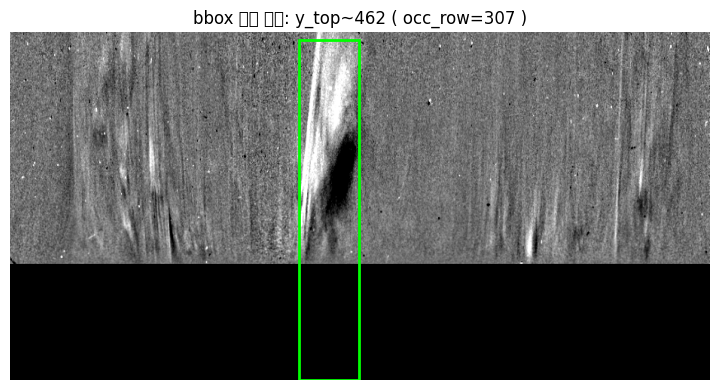

In [15]:
import json, math, numpy as np, cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

# -----------------------------------------
# 1) polar  →  bbox  (태양까지 포함)
# -----------------------------------------
def polar_to_bbox_include_sun(obj, W, H, occult_row):
    """
    θ·r 라벨 → [x0,y0,x1,y1]  (y1 = H)
    occult_row : 검은 띠 윗선 row,  r=0 에 해당
    """
    # θ → x 선형 맵
    t0, t1 = obj["theta_start"] % 360, obj["theta_end"] % 360
    r_max  = obj["radius_end"]                   # CME 최외곽
    px_per_deg = W / 360.0

    y_top = max(occult_row - r_max, 0)           # 꼭대기
    y_bot = H                                    # 태양까지 포함

    boxes = []
    if t0 <= t1:
        boxes.append([t0*px_per_deg, y_top, t1*px_per_deg, y_bot])
    else:  # 0° 경계 넘는 경우 두 박스
        boxes.append([0,              y_top, t1*px_per_deg, y_bot])
        boxes.append([t0*px_per_deg,  y_top, W,             y_bot])
    return boxes

# -----------------------------------------
# 2) 경계(row) 찾기  (한 번만 계산)
# -----------------------------------------
def find_occult_row(gray, thr=8):
    means = gray.mean(axis=1)
    for row in range(gray.shape[0]-1, -1, -1):
        if means[row] > thr:
            return row
    return gray.shape[0] - 1

# -----------------------------------------
# 3) 하나의 샘플로 테스트
# -----------------------------------------
IMG = Path("/data/minkyu/Kaist/Relation-DETR/datasets/final-dataset/train/diff_coordinate_image/c2_coordinate_lev1/2001/20011214/coordinate_20011214_232958.png")
LBL = Path("/data/minkyu/Kaist/Relation-DETR/datasets/final-dataset/train/labels/labels_20011214_232958.json")

img  = cv2.imread(str(IMG), cv2.IMREAD_GRAYSCALE)
H, W = img.shape
occult_row = find_occult_row(img)       # 예: 307

with LBL.open() as f:
    js = json.load(f)

bboxes = []
for obj in js["image"]["labels"]:
    bboxes.extend(polar_to_bbox_include_sun(obj, W, H, occult_row))

# -----------------------------------------
# 4) 시각화
# -----------------------------------------
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(img, cmap="gray")
for x0, y0, x1, y1 in bboxes:
    ax.add_patch(patches.Rectangle((x0, y0), x1-x0, y1-y0,
                                   linewidth=2, edgecolor="lime", facecolor="none"))
ax.set_xlim(0, W); ax.set_ylim(H, 0); ax.axis("off")
ax.set_title(f"bbox 포함 범위: y_top~{H} ( occ_row={occult_row} )")
plt.tight_layout(); plt.show()


In [3]:
import json, math, numpy as np, cv2

img = cv2.imread("/data/minkyu/Kaist/Relation-DETR/datasets/CME/images/train/20000101_002919.png.png")

img.shape

(500, 1000, 3)

In [4]:
import os
from pathlib import Path

# 경로를 수정하세요 (파일이 저장된 디렉토리)
image_dir = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/images/train")

# 잘못된 파일명을 찾아서 수정
renamed = []
for file in image_dir.rglob("*.png.png"):
    new_name = file.with_name(file.name.replace(".png.png", ".png"))
    os.rename(file, new_name)
    renamed.append((file.name, new_name.name))

# 결과 출력
print(f"{len(renamed)}개 파일 이름이 수정되었습니다.")
for before, after in renamed:
    print(f"{before}  →  {after}")


18143개 파일 이름이 수정되었습니다.
20010107_222943.png.png  →  20010107_222943.png
20000317_235352.png.png  →  20000317_235352.png
20010103_170207.png.png  →  20010103_170207.png
20000709_040450.png.png  →  20000709_040450.png
20010112_222950.png.png  →  20010112_222950.png
20011105_124326.png.png  →  20011105_124326.png
20010403_080550.png.png  →  20010403_080550.png
20000513_162552.png.png  →  20000513_162552.png
20010205_193139.png.png  →  20010205_193139.png
20010616_183458.png.png  →  20010616_183458.png
20010111_112847.png.png  →  20010111_112847.png
20000130_052845.png.png  →  20000130_052845.png
20001230_023028.png.png  →  20001230_023028.png
20010522_202556.png.png  →  20010522_202556.png
20010916_185354.png.png  →  20010916_185354.png
20001127_165146.png.png  →  20001127_165146.png
20011113_234957.png.png  →  20011113_234957.png
20000515_094958.png.png  →  20000515_094958.png
20010406_034959.png.png  →  20010406_034959.png
20010901_063424.png.png  →  20010901_063424.png
20010110_025323.p

In [5]:
#!/usr/bin/env python
"""
make_single_class.py

사용법
$ python make_single_class.py \
    /data/minkyu/Kaist/Relation-DETR/datasets/CME/annotations/instances_train.json \
    /data/minkyu/Kaist/Relation-DETR/datasets/CME/annotations/instances_val.json
"""
import json, sys, pathlib

def convert(json_path: str):
    path = pathlib.Path(json_path)
    coco = json.load(open(path))

    # 1) 모든 annotation 의 category_id → 0
    for ann in coco["annotations"]:
        ann["category_id"] = 0

    # 2) categories 리스트 단일 클래스(cme)로 교체
    coco["categories"] = [{"id": 0, "name": "cme"}]

    # 3) 새 파일 저장 (원본은 보존)
    out = path.with_name(path.stem + "_0.json")
    json.dump(coco, open(out, "w"))
    print(f"✅  saved single‑class file → {out}")

if __name__ == "__main__":
    for p in sys.argv[1:]:
        convert(p)


FileNotFoundError: [Errno 2] No such file or directory: '--f=/home/minkyu/.local/share/jupyter/runtime/kernel-v2-320785575bxKKzECbkn.json'

In [22]:
import json, random, os, shutil
from pathlib import Path
from tqdm import tqdm

# ------------------------------------------------------
# 사용자 설정
# ------------------------------------------------------
json_path = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/annotations/instances_train.json")  # 원본 COCO JSON
image_dir = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/images")                # 원본 이미지 디렉토리
output_root = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/CME_split")              # 결과 저장 디렉토리
split_ratio = 0.1
seed = 42

# ------------------------------------------------------
# 디렉토리 세팅
# ------------------------------------------------------
train_dir = output_root / "train"
val_dir = output_root / "val"
ann_dir = output_root / "annotations"
train_dir.mkdir(parents=True, exist_ok=True)
val_dir.mkdir(parents=True, exist_ok=True)
ann_dir.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------
# JSON 불러오기
# ------------------------------------------------------
with open(json_path, "r") as f:
    coco = json.load(f)

# ------------------------------------------------------
# 이미지 분할 (9:1)
# ------------------------------------------------------
images = coco["images"]
random.seed(seed)
random.shuffle(images)
n_val = int(len(images) * split_ratio)
val_images = images[:n_val]
train_images = images[n_val:]
val_ids = {im["id"] for im in val_images}
train_ids = {im["id"] for im in train_images}

def make_subset(ids, images):
    return {
        **{k: v for k, v in coco.items() if k not in ("images", "annotations")},
        "images": images,
        "annotations": [ann for ann in coco["annotations"] if ann["image_id"] in ids]
    }

train_json = make_subset(train_ids, train_images)
val_json   = make_subset(val_ids, val_images)

# ------------------------------------------------------
# 이미지 복사
# ------------------------------------------------------
for im in tqdm(train_images, desc="Copying train"):
    src = image_dir / im["file_name"]
    dst = train_dir / im["file_name"]
    dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst)

for im in tqdm(val_images, desc="Copying val"):
    src = image_dir / im["file_name"]
    dst = val_dir / im["file_name"]
    dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst)

# ------------------------------------------------------
# JSON 저장
# ------------------------------------------------------
with open(ann_dir / "instances_train.json", "w") as f:
    json.dump(train_json, f)
with open(ann_dir / "instances_val.json", "w") as f:
    json.dump(val_json, f)

print("✅ 작업 완료. 총 이미지 수:", len(images), "| train:", len(train_images), "| val:", len(val_images))


Copying val: 100%|██████████| 1814/1814 [00:00<00:00, 1890.25it/s]


✅ 작업 완료. 총 이미지 수: 18143 | train: 16329 | val: 1814


In [47]:
import json
from pathlib import Path

# 파일 경로
train_path = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/CME_split/annotations/instances_train.json")
val_path = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/CME_split/annotations/instances_val.json")

# JSON 불러오기
with open(train_path, "r") as f:
    train_json = json.load(f)

with open(val_path, "r") as f:
    val_json = json.load(f)

# 모든 annotation의 category_id를 0으로 설정
for ann in train_json["annotations"]:
    ann["category_id"] = 0

for ann in val_json["annotations"]:
    ann["category_id"] = 0

# category 항목도 단일 클래스 0으로 재설정 (선택 사항)
train_json["categories"] = [{"id": 0, "name": "cme"}]
val_json["categories"]   = [{"id": 0, "name": "cme"}]

# 저장
with open(train_path, "w") as f:
    json.dump(train_json, f)

with open(val_path, "w") as f:
    json.dump(val_json, f)

print("✅ category_id 전부 0으로 수정 완료!")


✅ category_id 전부 0으로 수정 완료!


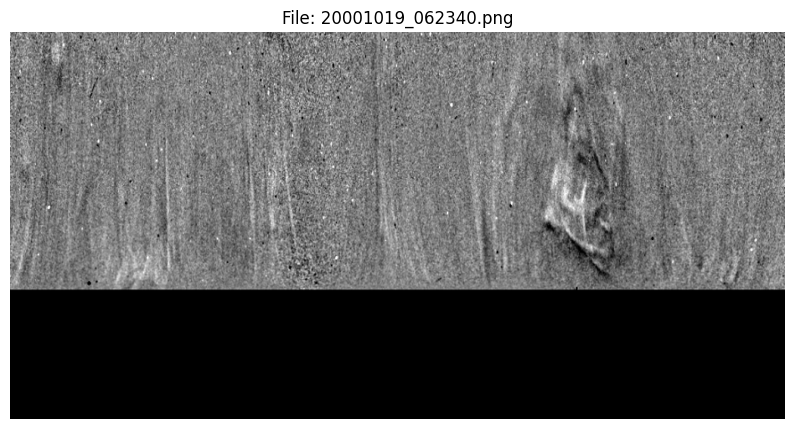

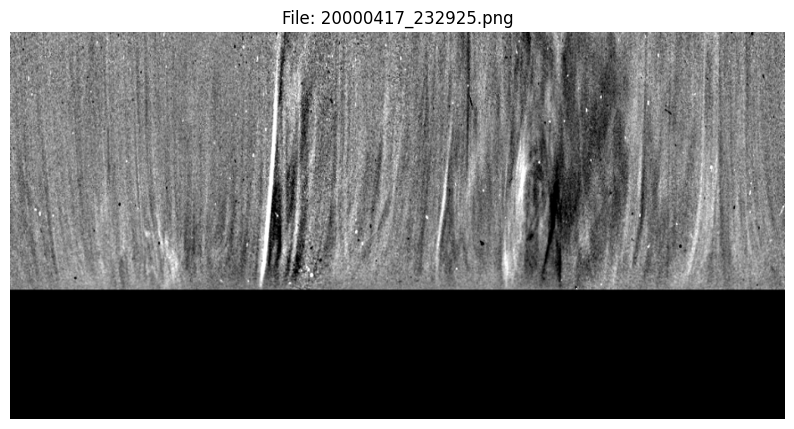

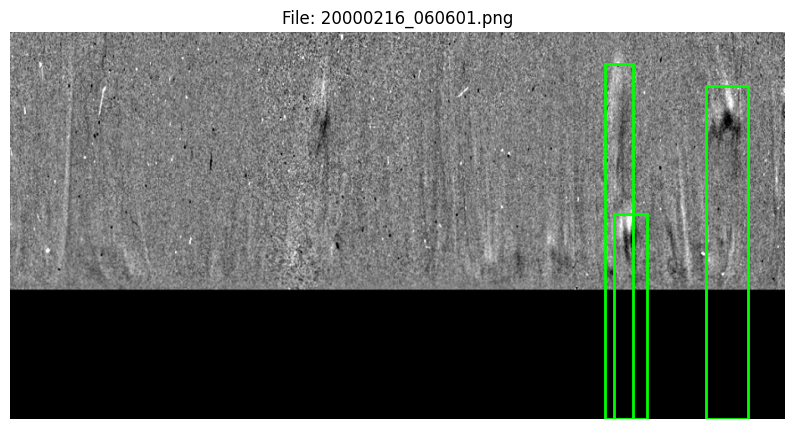

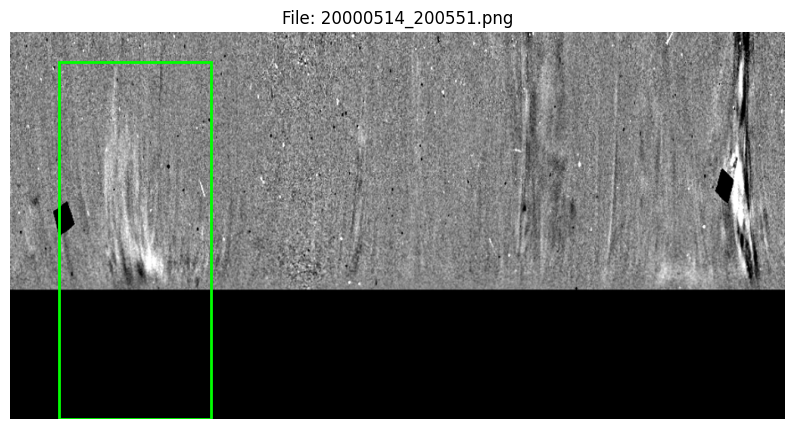

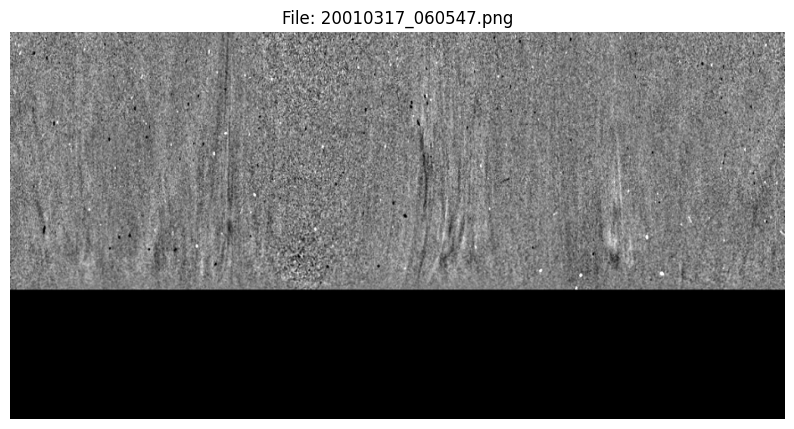

In [82]:
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image

# -----------------------------------------------------
# 경로 설정
# -----------------------------------------------------
ann_path = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/CME_split/annotations/instances_val.json")
img_dir = Path("/data/minkyu/Kaist/Relation-DETR/datasets/CME/CME_split/val")

# -----------------------------------------------------
# JSON 로드
# -----------------------------------------------------
with open(ann_path, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]

# image_id → file_name
id_to_filename = {img["id"]: img["file_name"] for img in images}

# image_id → 해당 bbox들
from collections import defaultdict
id_to_boxes = defaultdict(list)
for ann in annotations:
    id_to_boxes[ann["image_id"]].append(ann["bbox"])

# -----------------------------------------------------
# 랜덤 시각화 5장
# -----------------------------------------------------
sample_ids = random.sample(list(id_to_filename.keys()), 5)

for image_id in sample_ids:
    file_name = id_to_filename[image_id]
    bboxes = id_to_boxes[image_id]
    img_path = img_dir / file_name
    img = Image.open(img_path).convert("RGB")

    # 시각화
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(img)

    for bbox in bboxes:
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"File: {file_name}")
    plt.axis("off")
    plt.show()


In [28]:
import os
from PIL import Image
import numpy as np

def get_image_shapes(root_dir):
    shapes = []

    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith('.png'):
                fpath = os.path.join(dirpath, fname)
                try:
                    with Image.open(fpath) as img:
                        shapes.append(img.size)  # (width, height)
                except Exception as e:
                    print(f"Error reading {fpath}: {e}")

    return shapes

def analyze_shapes(shapes):
    if not shapes:
        print("No PNG images found.")
        return

    widths, heights = zip(*shapes)
    widths = np.array(widths)
    heights = np.array(heights)

    print(f"Total images: {len(shapes)}")
    print(f"Width  → min: {widths.min()}, max: {widths.max()}, mean: {widths.mean():.2f}")
    print(f"Height → min: {heights.min()}, max: {heights.max()}, mean: {heights.mean():.2f}")

if __name__ == "__main__":
    root_dir = "/data/minkyu/vis_out_0.5"
    shapes = get_image_shapes(root_dir)
    analyze_shapes(shapes)


Total images: 9071
Width  → min: 1024, max: 1024, mean: 1024.00
Height → min: 512, max: 512, mean: 512.00


In [27]:
import cv2

img = cv2.imread("/data/minkyu/Kaist/Relation-DETR/datasets/final-dataset/test_one.png")

img.shape

(512, 1024, 3)

In [23]:
#!/usr/bin/env python3
# run_infer_vis_single.py
# -----------------------------------------------
# 1장 이미지만 추론, bbox 시각화 및 shape 확인용
# -----------------------------------------------
import os, sys, pathlib, cv2, numpy as np, torch
from util.lazy_load import Config
from util.utils import load_state_dict

# ───────────── 사용자 설정 ──────────────
ckpt_path = "/data/minkyu/Kaist/Relation-DETR/experiments/cme_convnext_b_q10_bbox5_augplus/best_ap50.pth"
cfg_path  = "/data/minkyu/Kaist/Relation-DETR/configs/relation_detr/relation_detr_convnext_b_500_1000.py"
img_path  = "/data/minkyu/Kaist/Relation-DETR/datasets/final-dataset/test/diff_coordinate_image/c2_coordinate_lev1/2000/20000101/coordinate_20000101_000123.png"
vis_path  = "test_one.png"
conf_thresh = 0.50
device      = "cuda"
font_scale  = 0.5
# ───────────────────────────────────────

# PYTHONPATH 설정
proj_root = pathlib.Path(__file__).resolve().parents[1]
if str(proj_root) not in sys.path:
    sys.path.append(str(proj_root))

# 모델 로드
cfg   = Config(cfg_path)
model = cfg.model
state = torch.load(ckpt_path, map_location="cpu")
load_state_dict(model, state.get("model", state))
model.to(device).eval()
print(f"[✓] 모델 로드 완료")

# 이미지 로드
im_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
print(f"[✓] 원본 이미지 shape (HWC): {im_bgr.shape}")  # (H, W, C)

im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
inp    = torch.from_numpy(im_rgb.transpose(2, 0, 1)).float() / 255.
print(f"[✓] 입력 텐서 shape (CHW): {inp.shape}")

# 추론
with torch.no_grad():
    out = model([inp.to(device)])[0]

boxes  = out["boxes"].cpu().numpy()
scores = out["scores"].cpu().numpy()

drawn = 0
for box, s in zip(boxes, scores):
    if s < conf_thresh:
        continue
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(im_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
    text = f"CME {s:.2f}"
    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
    cv2.rectangle(im_bgr, (x1, y1 - th - 4), (x1 + tw, y1), (0, 255, 0), -1)
    cv2.putText(im_bgr, text, (x1, y1 - 2),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), 1, cv2.LINE_AA)
    print(f"[✓] Box {drawn+1}: score={s:.4f}, coords=({x1}, {y1}, {x2}, {y2})")
    drawn += 1

# 결과 저장
os.makedirs(os.path.dirname(vis_path), exist_ok=True)
cv2.imwrite(vis_path, im_bgr)
print(f"[✓] 박스 {drawn}개 시각화 저장 완료 → {vis_path}")


ModuleNotFoundError: No module named 'omegaconf'